/Users/behzadbojnordiarbab/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


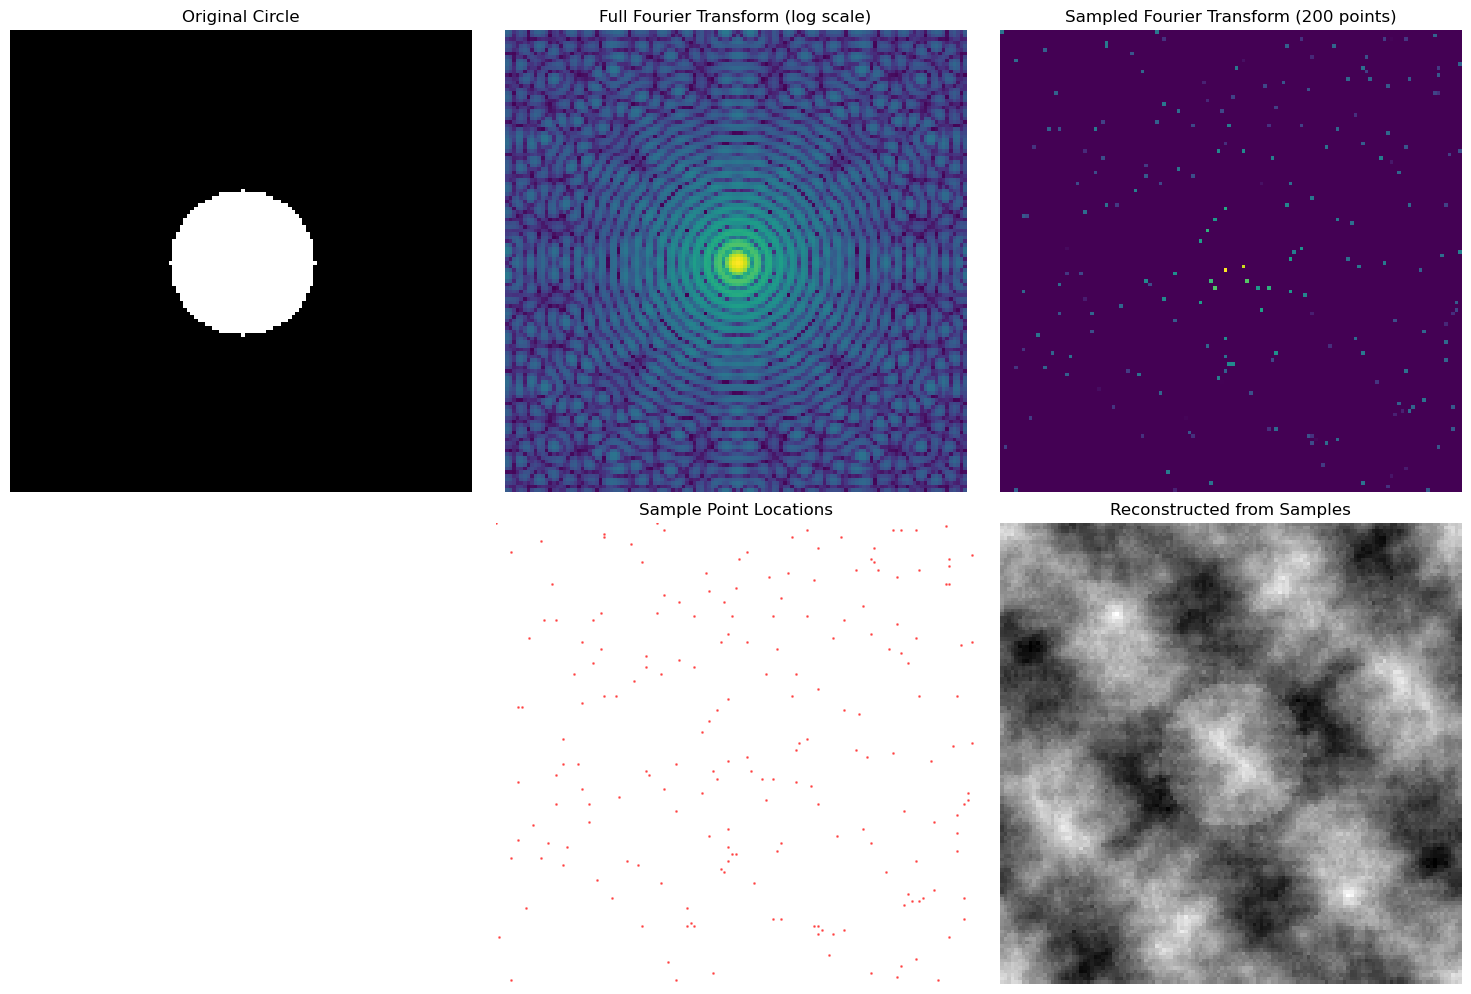

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy.interpolate import griddata
import random

# Create the original circle image
def create_circle_image(image_size=128, radius=20):
    """Create a filled circle in a black background."""
    img = np.zeros((image_size, image_size))
    center = (image_size // 2, image_size // 2)
    
    # Create coordinate grids
    y, x = np.ogrid[:image_size, :image_size]
    
    # Create mask for circle
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    img[mask] = 1.0  # Set circle pixels to white
    
    return img

# Perform Fourier transform and sample points
def sample_fourier(img, n_samples=500):
    """Take Fourier transform and sample random points."""
    # Compute 2D FFT
    f_transform = fft.fft2(img)
    f_transform_shifted = fft.fftshift(f_transform)  # Shift zero frequency to center
    
    # Create sampling mask for random points
    height, width = img.shape
    sample_mask = np.zeros((height, width), dtype=bool)
    
    # Get all possible indices and randomly sample n_samples of them
    indices = [(i, j) for i in range(height) for j in range(width)]
    sampled_indices = random.sample(indices, n_samples)
    
    # Create sparse array with only sampled points
    sparse_f_transform = np.zeros_like(f_transform_shifted, dtype=complex)
    for i, j in sampled_indices:
        sample_mask[i, j] = True
        sparse_f_transform[i, j] = f_transform_shifted[i, j]
    
    return f_transform_shifted, sparse_f_transform, sample_mask, sampled_indices

# Reconstruct image from sampled Fourier points
def reconstruct_from_samples(sparse_f_transform):
    """Reconstruct image from sampled Fourier points."""
    # Inverse shift and transform
    f_inverse_shifted = sparse_f_transform
    f_inverse = fft.ifftshift(f_inverse_shifted)
    reconstructed = fft.ifft2(f_inverse)
    
    # Extract real part (imaginary part should be very small)
    return np.real(reconstructed)

# Set parameters
image_size = 128
circle_radius = 20
n_samples = 200  # Number of random samples to take in Fourier space

# Create image
original_img = create_circle_image(image_size, circle_radius)

# Process image
fourier_transform, sparse_fourier, sample_mask, sample_points = sample_fourier(original_img, n_samples)
reconstructed_img = reconstruct_from_samples(sparse_fourier)

# Display results
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Circle')
plt.axis('off')

# Full Fourier transform (log scale for better visualization)
plt.subplot(2, 3, 2)
plt.imshow(np.log1p(np.abs(fourier_transform)), cmap='viridis')
plt.title('Full Fourier Transform (log scale)')
plt.axis('off')

# Sampled points in Fourier space
plt.subplot(2, 3, 3)
plt.imshow(np.log1p(np.abs(sparse_fourier)), cmap='viridis')
plt.title(f'Sampled Fourier Transform ({n_samples} points)')
plt.axis('off')

# Sample locations
plt.subplot(2, 3, 5)
plt.scatter([p[1] for p in sample_points], [p[0] for p in sample_points], 
            s=1, alpha=0.5, c='red')
plt.xlim(0, image_size)
plt.ylim(0, image_size)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.title('Sample Point Locations')
plt.axis('off')

# Reconstructed image
plt.subplot(2, 3, 6)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed from Samples')
plt.axis('off')

plt.tight_layout()
plt.show()

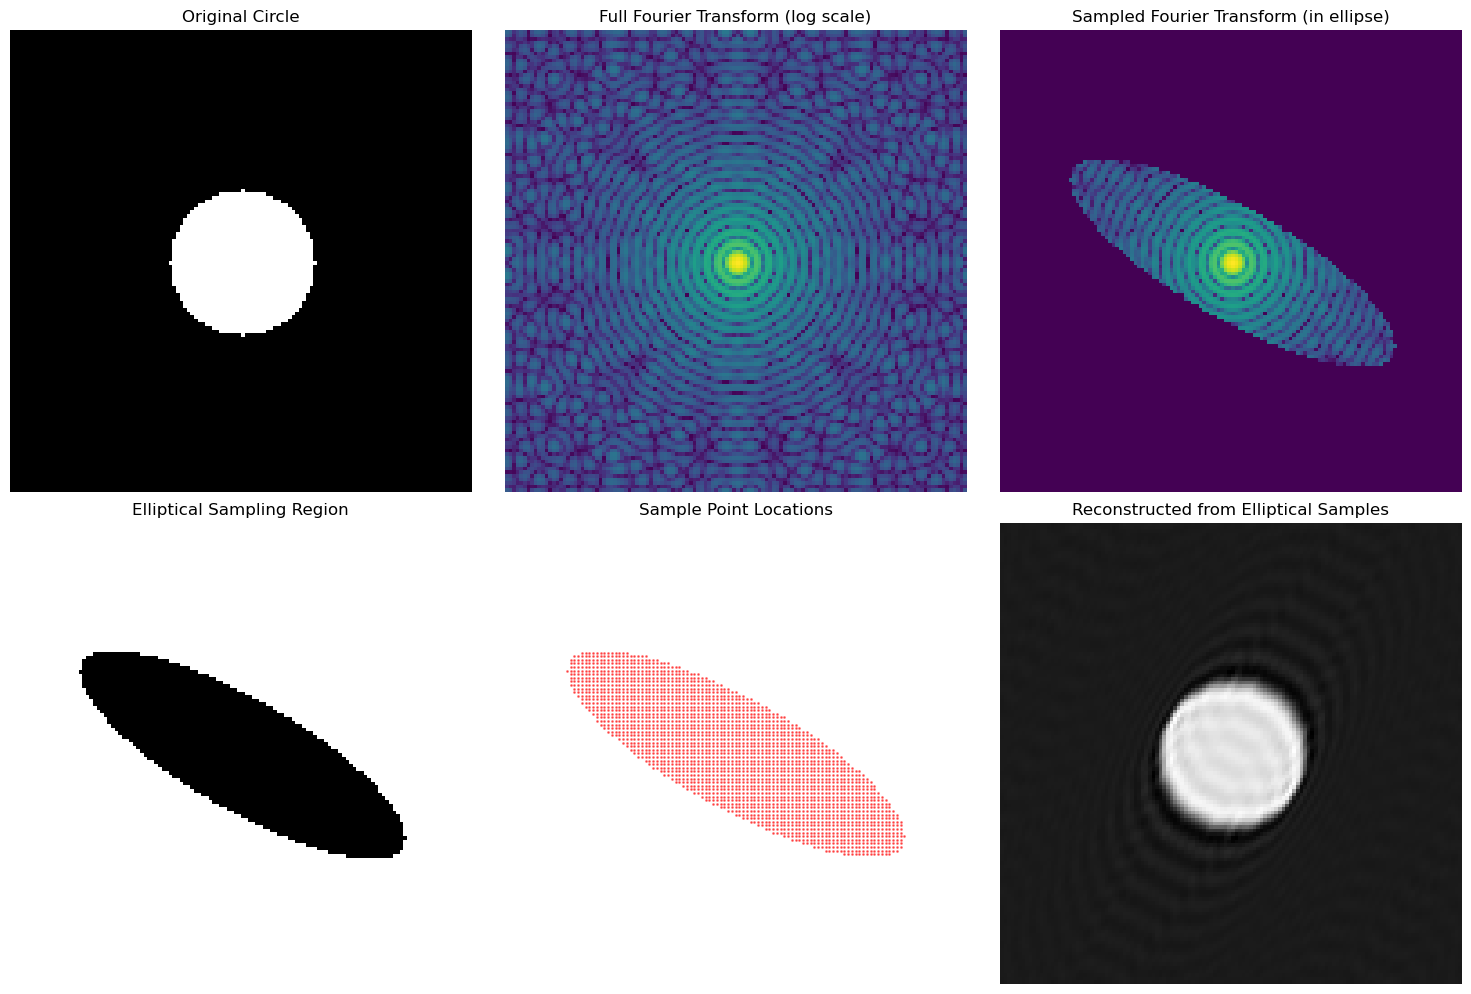

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
import random

# Create the original circle image
def create_circle_image(image_size=128, radius=20):
    """Create a filled circle in a black background."""
    img = np.zeros((image_size, image_size))
    center = (image_size // 2, image_size // 2)
    
    # Create coordinate grids
    y, x = np.ogrid[:image_size, :image_size]
    
    # Create mask for circle
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    img[mask] = 1.0  # Set circle pixels to white
    
    return img

# Perform Fourier transform and sample points within an ellipse
def sample_fourier_ellipse(img, n_samples=500, a_ratio=0.6, rotation_angle=30):
    """
    Take Fourier transform and sample random points within an ellipse.
    
    Parameters:
    -----------
    img : ndarray
        Input image
    n_samples : int
        Number of samples to take
    a_ratio : float
        Ratio of minor to major axis (0-1)
    rotation_angle : float
        Rotation angle of ellipse in degrees
    """
    # Compute 2D FFT
    f_transform = fft.fft2(img)
    f_transform_shifted = fft.fftshift(f_transform)  # Shift zero frequency to center
    
    # Create sampling mask for random points
    height, width = img.shape
    center_y, center_x = height // 2, width // 2
    
    # Major axis length (half the image size)
    a = min(height, width) * 0.4
    # Minor axis length
    b = a * a_ratio
    
    # Convert rotation angle to radians
    theta = np.deg2rad(rotation_angle)
    
    # Get all possible indices
    indices = []
    for i in range(height):
        for j in range(width):
            # Translate coordinates to origin
            y, x = i - center_y, j - center_x
            
            # Apply rotation
            x_rot = x * np.cos(theta) + y * np.sin(theta)
            y_rot = -x * np.sin(theta) + y * np.cos(theta)
            
            # Check if point is within ellipse
            if (x_rot**2 / a**2 + y_rot**2 / b**2) <= 1:
                indices.append((i, j))
    
    # If there are fewer points in the ellipse than requested samples,
    # adjust n_samples
    if len(indices) < n_samples:
        n_samples = len(indices)
        print(f"Warning: Only {n_samples} points are available in the ellipse")
    
    # Randomly sample n_samples from the ellipse
    sampled_indices = random.sample(indices, n_samples)
    
    # Create sparse array with only sampled points
    sparse_f_transform = np.zeros_like(f_transform_shifted, dtype=complex)
    ellipse_mask = np.zeros((height, width), dtype=bool)
    
    for i, j in sampled_indices:
        ellipse_mask[i, j] = True
        sparse_f_transform[i, j] = f_transform_shifted[i, j]
    
    return f_transform_shifted, sparse_f_transform, ellipse_mask, sampled_indices

# Reconstruct image from sampled Fourier points
def reconstruct_from_samples(sparse_f_transform):
    """Reconstruct image from sampled Fourier points."""
    # Inverse shift and transform
    f_inverse = fft.ifftshift(sparse_f_transform)
    reconstructed = fft.ifft2(f_inverse)
    
    # Extract real part (imaginary part should be very small)
    return np.real(reconstructed)

# Set parameters
image_size = 128
circle_radius = 20
n_samples = 100000  # Number of random samples to take in Fourier space

# Create image
original_img = create_circle_image(image_size, circle_radius)

# Process image with elliptical sampling
fourier_transform, sparse_fourier, ellipse_mask, sample_points = sample_fourier_ellipse(
    original_img, n_samples=n_samples, a_ratio=0.3, rotation_angle=30
)
reconstructed_img = reconstruct_from_samples(sparse_fourier)

# Create a visualization of the elliptical sampling region
ellipse_region = np.zeros((image_size, image_size))
for i, j in sample_points:
    ellipse_region[i, j] = 1

# Display results
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Circle')
plt.axis('off')

# Full Fourier transform (log scale for better visualization)
plt.subplot(2, 3, 2)
plt.imshow(np.log1p(np.abs(fourier_transform)), cmap='viridis')
plt.title('Full Fourier Transform (log scale)')
plt.axis('off')

# Sampled points in Fourier space
plt.subplot(2, 3, 3)
plt.imshow(np.log1p(np.abs(sparse_fourier)), cmap='viridis')
plt.title(f'Sampled Fourier Transform (in ellipse)')
plt.axis('off')

# Elliptical sampling region
plt.subplot(2, 3, 4)
plt.imshow(ellipse_mask, cmap='Greys')
plt.title('Elliptical Sampling Region')
plt.axis('off')

# Sample locations
plt.subplot(2, 3, 5)
plt.scatter([p[1] for p in sample_points], [p[0] for p in sample_points], 
            s=1, alpha=0.5, c='red')
plt.xlim(0, image_size)
plt.ylim(0, image_size)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.title('Sample Point Locations')
plt.axis('off')

# Reconstructed image
plt.subplot(2, 3, 6)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed from Elliptical Samples')
plt.axis('off')

plt.tight_layout()
plt.show()

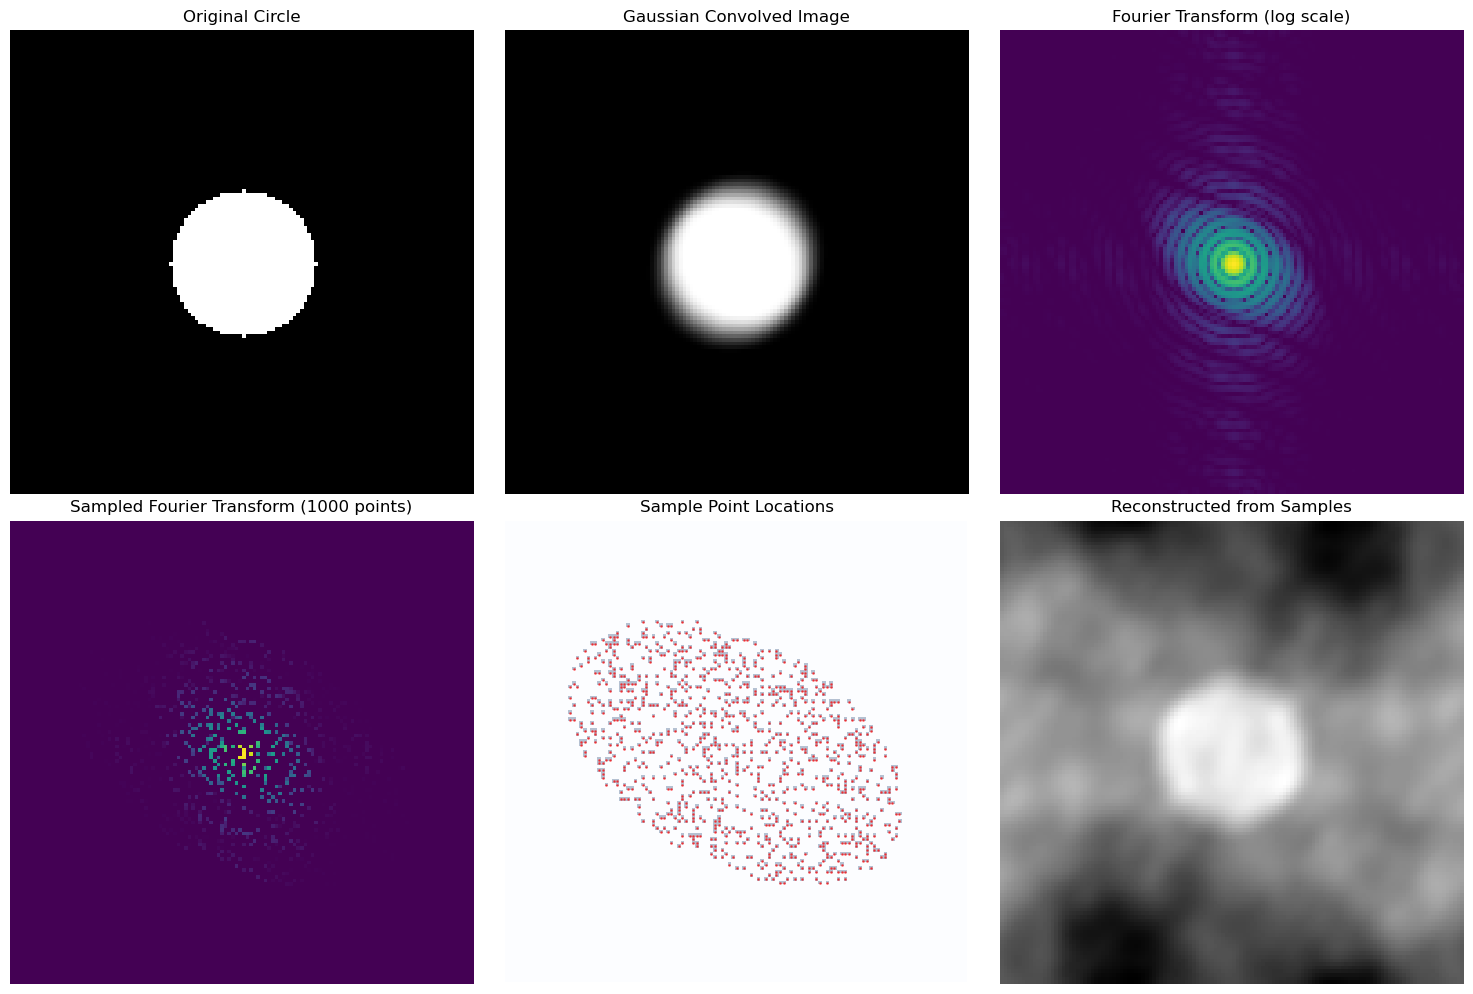

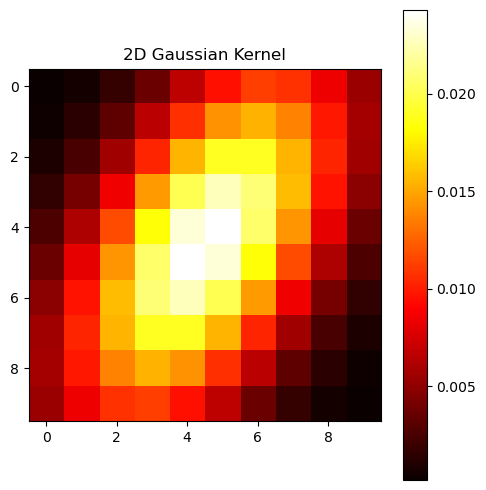

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft, ndimage
import random

# Create the original circle image
def create_circle_image(image_size=128, radius=20):
    """Create a filled circle in a black background."""
    img = np.zeros((image_size, image_size))
    center = (image_size // 2, image_size // 2)
    
    # Create coordinate grids
    y, x = np.ogrid[:image_size, :image_size]
    
    # Create mask for circle
    mask = (x - center[0])**2 + (y - center[1])**2 <= radius**2
    img[mask] = 1.0  # Set circle pixels to white
    
    return img

# Create a 2D Gaussian kernel for convolution
def gaussian_kernel(size, sigma_x=3, sigma_y=3, theta=0):
    """
    Create a 2D Gaussian kernel with the specified parameters.
    
    Parameters:
    -----------
    size : int
        Size of the kernel (square)
    sigma_x, sigma_y : float
        Standard deviations in x and y directions
    theta : float
        Rotation angle in degrees
    """
    # Convert theta to radians
    theta = np.deg2rad(theta)
    
    # Create a meshgrid of coordinates
    x = np.arange(0, size, 1, float) - (size-1)/2
    y = np.arange(0, size, 1, float) - (size-1)/2
    xx, yy = np.meshgrid(x, y)
    
    # Rotate coordinates
    x_rot = xx * np.cos(theta) + yy * np.sin(theta)
    y_rot = -xx * np.sin(theta) + yy * np.cos(theta)
    
    # Calculate the 2D Gaussian function
    kernel = np.exp(-(x_rot**2 / (2*sigma_x**2) + y_rot**2 / (2*sigma_y**2)))
    
    # Normalize the kernel
    return kernel / np.sum(kernel)

# Perform Fourier transform and sample points within an ellipse
def sample_fourier_ellipse(img, n_samples=500, a_ratio=0.6, rotation_angle=30):
    """
    Take Fourier transform and sample random points within an ellipse.
    
    Parameters:
    -----------
    img : ndarray
        Input image
    n_samples : int
        Number of samples to take
    a_ratio : float
        Ratio of minor to major axis (0-1)
    rotation_angle : float
        Rotation angle of ellipse in degrees
    """
    # Compute 2D FFT
    f_transform = fft.fft2(img)
    f_transform_shifted = fft.fftshift(f_transform)  # Shift zero frequency to center
    
    # Create sampling mask for random points
    height, width = img.shape
    center_y, center_x = height // 2, width // 2
    
    # Major axis length (half the image size)
    a = min(height, width) * 0.4
    # Minor axis length
    b = a * a_ratio
    
    # Convert rotation angle to radians
    theta = np.deg2rad(rotation_angle)
    
    # Get all possible indices
    indices = []
    for i in range(height):
        for j in range(width):
            # Translate coordinates to origin
            y, x = i - center_y, j - center_x
            
            # Apply rotation
            x_rot = x * np.cos(theta) + y * np.sin(theta)
            y_rot = -x * np.sin(theta) + y * np.cos(theta)
            
            # Check if point is within ellipse
            if (x_rot**2 / a**2 + y_rot**2 / b**2) <= 1:
                indices.append((i, j))
    
    # If there are fewer points in the ellipse than requested samples,
    # adjust n_samples
    if len(indices) < n_samples:
        n_samples = len(indices)
        print(f"Warning: Only {n_samples} points are available in the ellipse")
    
    # Randomly sample n_samples from the ellipse
    sampled_indices = random.sample(indices, n_samples)
    
    # Create sparse array with only sampled points
    sparse_f_transform = np.zeros_like(f_transform_shifted, dtype=complex)
    ellipse_mask = np.zeros((height, width), dtype=bool)
    
    for i, j in sampled_indices:
        ellipse_mask[i, j] = True
        sparse_f_transform[i, j] = f_transform_shifted[i, j]
    
    return f_transform_shifted, sparse_f_transform, ellipse_mask, sampled_indices

# Reconstruct image from sampled Fourier points
def reconstruct_from_samples(sparse_f_transform):
    """Reconstruct image from sampled Fourier points."""
    # Inverse shift and transform
    f_inverse = fft.ifftshift(sparse_f_transform)
    reconstructed = fft.ifft2(f_inverse)
    
    # Extract real part (imaginary part should be very small)
    return np.real(reconstructed)

# Set parameters
image_size = 128
circle_radius = 20
n_samples = 1000  # Number of random samples to take in Fourier space
gauss_sigma_x = 2.0  # Standard deviation for Gaussian in x direction
gauss_sigma_y = 4.0  # Standard deviation for Gaussian in y direction
gauss_theta = 30  # Rotation angle for the Gaussian kernel in degrees

# Create image
original_img = create_circle_image(image_size, circle_radius)

# Create Gaussian kernel and convolve with the image
kernel_size = 10  # Should be odd and large enough for the sigma values
gaussian = gaussian_kernel(kernel_size, gauss_sigma_x, gauss_sigma_y, gauss_theta)
convolved_img = ndimage.convolve(original_img, gaussian, mode='constant', cval=0.0)

# Process the convolved image with elliptical sampling
fourier_transform, sparse_fourier, ellipse_mask, sample_points = sample_fourier_ellipse(
    convolved_img, n_samples=n_samples, a_ratio=0.6, rotation_angle=30
)
reconstructed_img = reconstruct_from_samples(sparse_fourier)

# Display results
plt.figure(figsize=(15, 10))

# Original image
plt.subplot(2, 3, 1)
plt.imshow(original_img, cmap='gray')
plt.title('Original Circle')
plt.axis('off')

# Convolved image (with Gaussian)
plt.subplot(2, 3, 2)
plt.imshow(convolved_img, cmap='gray')
plt.title('Gaussian Convolved Image')
plt.axis('off')

# Full Fourier transform of convolved image
plt.subplot(2, 3, 3)
plt.imshow(np.log1p(np.abs(fourier_transform)), cmap='viridis')
plt.title('Fourier Transform (log scale)')
plt.axis('off')

# Sampled points in Fourier space
plt.subplot(2, 3, 4)
plt.imshow(np.log1p(np.abs(sparse_fourier)), cmap='viridis')
plt.title(f'Sampled Fourier Transform ({n_samples} points)')
plt.axis('off')

# Sample locations
plt.subplot(2, 3, 5)
plt.scatter([p[1] for p in sample_points], [p[0] for p in sample_points], 
            s=1, alpha=0.5, c='red')
plt.imshow(ellipse_mask, alpha=0.3, cmap='Blues')
plt.xlim(0, image_size)
plt.ylim(0, image_size)
plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
plt.title('Sample Point Locations')
plt.axis('off')

# Reconstructed image
plt.subplot(2, 3, 6)
plt.imshow(reconstructed_img, cmap='gray')
plt.title('Reconstructed from Samples')
plt.axis('off')

plt.tight_layout()
plt.show()

# Show the Gaussian kernel
plt.figure(figsize=(5, 5))
plt.imshow(gaussian, cmap='hot')
plt.colorbar()
plt.title('2D Gaussian Kernel')
plt.tight_layout()
plt.show()